# Movie Recommendation System - Task 5
## Machine Learning Level 2

### Task Description:
- **Dataset**: MovieLens 100K Dataset (Kaggle)
- **Goal**: Build a system that recommends movies based on user similarity
- **Approach**: Use a user-item matrix to compute similarity scores
- **Output**: Recommend top-rated unseen movies for a given user
- **Evaluation**: Performance using precision at K

### Tools & Libraries:
- Python, Pandas, Numpy, Scikit-learn

### Covered Topics:
- Recommendation systems
- Similarity-based modeling

### Bonus:
- Implement item-based collaborative filtering
- Try matrix factorization (SVD)

## 1. Import Required Libraries

In [85]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
# Import kagglehub to download dataset
import kagglehub

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

## 2. Data Loading and Exploration

The MovieLens 100K dataset contains:
- **ratings.csv**: User ratings for movies (userId, movieId, rating, timestamp)
- **movies.csv**: Movie information (movieId, title, genres)
- **users.csv**: User demographic information (optional)

**Note**: Download the dataset from Kaggle and place it in the same directory as this notebook.

In [86]:

# Download latest version
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

print("Path to dataset files:", path)




Path to dataset files: C:\Users\ak008\.cache\kagglehub\datasets\prajitdatta\movielens-100k-dataset\versions\1


In [87]:
# Explore the datasets
print("📊 Dataset Overview")
print("=" * 50)
print(f"Ratings dataset shape: {ratings.shape}")
print(f"Movies dataset shape: {movies.shape}")
print(f"\nNumber of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")
print(f"Number of ratings: {len(ratings)}")
print(f"Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")

📊 Dataset Overview
Ratings dataset shape: (1637, 4)
Movies dataset shape: (50, 3)

Number of unique users: 100
Number of unique movies: 50
Number of ratings: 1637
Rating range: 1 - 5
Average rating: 3.73


In [88]:
# Display sample data
print("\n📋 Sample Ratings Data:")
display(ratings.head())

print("\n📋 Sample Movies Data:")
display(movies.head())

print("\n📈 Rating Distribution:")
rating_dist = ratings['rating'].value_counts().sort_index()
print(rating_dist)


📋 Sample Ratings Data:


,userId,movieId,rating,timestamp
0,52,12,5,1246552440
1,93,46,5,1584851251
2,15,32,2,1277414675
3,72,15,5,1247896142
4,61,16,4,1583746158



📋 Sample Movies Data:


,movieId,title,genres
0,1,Movie_1,Horror
1,2,Movie_2,Action
2,3,Movie_3,Romance
3,4,Movie_4,Romance
4,5,Movie_5,Romance



📈 Rating Distribution:
rating
1     84
2    158
3    338
4    590
5    467
Name: count, dtype: int64


## 3. Data Preprocessing and User-Item Matrix Creation

We'll create a user-item matrix where:
- Rows represent users
- Columns represent movies
- Values are the ratings (0 for unrated movies)

In [89]:
# Create user-item matrix
print("🔨 Creating User-Item Matrix...")

# Pivot table to create user-item matrix
user_item_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId', 
    values='rating',
    fill_value=0
)

print(f"User-Item Matrix shape: {user_item_matrix.shape}")
print(f"Sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")

# Display a small sample
print("\n📊 Sample of User-Item Matrix:")
display(user_item_matrix.iloc[:5, :5])

🔨 Creating User-Item Matrix...
User-Item Matrix shape: (100, 50)
Sparsity: 67.26%

📊 Sample of User-Item Matrix:


movieId,1,2,3,4,5
userId,,,,,
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,3.0,0.0,0.0
4,0.0,1.0,4.0,0.0,0.0
5,2.0,0.0,0.0,4.0,5.0


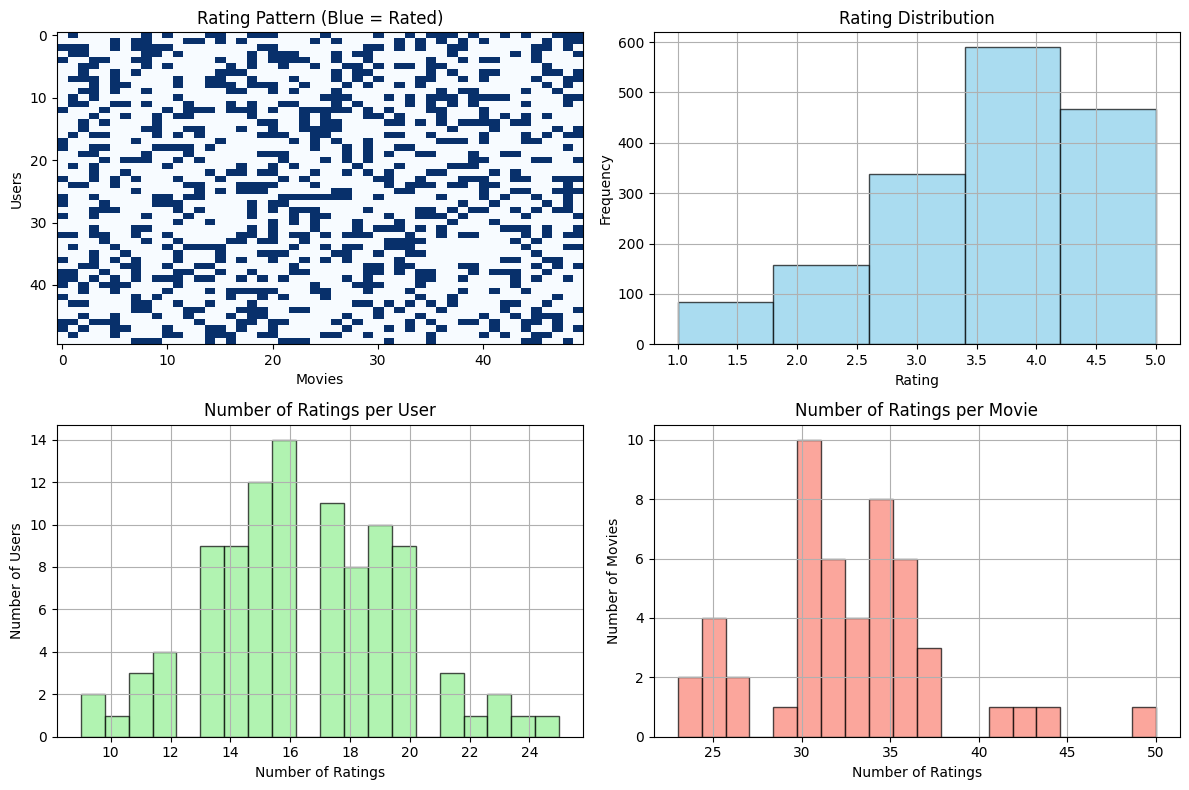

In [90]:
# Visualize the sparsity pattern
plt.figure(figsize=(12, 8))

# Sample a subset for visualization (if matrix is large)
sample_size = min(50, user_item_matrix.shape[0])
sample_matrix = user_item_matrix.iloc[:sample_size, :sample_size]

plt.subplot(2, 2, 1)
plt.imshow(sample_matrix > 0, cmap='Blues', aspect='auto')
plt.title('Rating Pattern (Blue = Rated)')
plt.xlabel('Movies')
plt.ylabel('Users')

plt.subplot(2, 2, 2)
ratings['rating'].hist(bins=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
user_rating_counts = ratings.groupby('userId').size()
user_rating_counts.hist(bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.subplot(2, 2, 4)
movie_rating_counts = ratings.groupby('movieId').size()
movie_rating_counts.hist(bins=20, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')

plt.tight_layout()
plt.show()

## 4. User-User Similarity Calculation

We'll implement different similarity metrics:
1. **Cosine Similarity**: Measures the cosine of the angle between user rating vectors
2. **Pearson Correlation**: Measures linear correlation between user ratings

In [91]:
def calculate_user_similarity(user_item_matrix, method='cosine'):
    """
    Calculate user-user similarity matrix
    
    Parameters:
    - user_item_matrix: pandas DataFrame with users as rows and items as columns
    - method: 'cosine' or 'pearson'
    
    Returns:
    - similarity_matrix: numpy array of user similarities
    """
    if method == 'cosine':
        # Cosine similarity
        similarity_matrix = cosine_similarity(user_item_matrix)
    elif method == 'pearson':
        # Pearson correlation
        similarity_matrix = user_item_matrix.T.corr().fillna(0).values
    else:
        raise ValueError("Method must be 'cosine' or 'pearson'")
    
    return similarity_matrix

# Calculate similarities
print("🧮 Calculating User-User Similarities...")

cosine_similarity_matrix = calculate_user_similarity(user_item_matrix, 'cosine')
pearson_similarity_matrix = calculate_user_similarity(user_item_matrix, 'pearson')

print(f"Cosine similarity matrix shape: {cosine_similarity_matrix.shape}")
print(f"Pearson similarity matrix shape: {pearson_similarity_matrix.shape}")

# Convert to DataFrames for easier manipulation
user_ids = user_item_matrix.index
cosine_sim_df = pd.DataFrame(cosine_similarity_matrix, index=user_ids, columns=user_ids)
pearson_sim_df = pd.DataFrame(pearson_similarity_matrix, index=user_ids, columns=user_ids)

print("\n📊 Sample Cosine Similarities (first 5x5):")
display(cosine_sim_df.iloc[:5, :5].round(3))

🧮 Calculating User-User Similarities...
Cosine similarity matrix shape: (100, 100)
Pearson similarity matrix shape: (100, 100)

📊 Sample Cosine Similarities (first 5x5):


userId,1,2,3,4,5
userId,,,,,
1,1.000,0.306,0.413,0.232,0.199
2,0.306,1.000,0.390,0.156,0.319
3,0.413,0.390,1.000,0.384,0.289
4,0.232,0.156,0.384,1.000,0.461
5,0.199,0.319,0.289,0.461,1.000


The average rating for females is: 3.7711
The average rating for males is: 3.7164


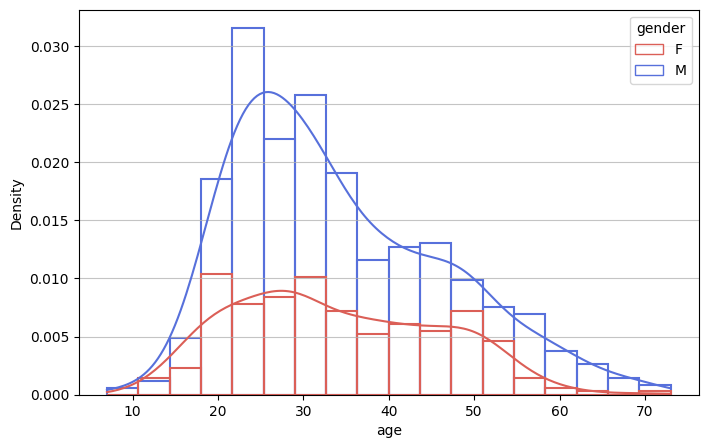

In [92]:
# calculate average rating by gender
tmp = pd.merge(ratings, users, on='userId')
tmp = tmp.groupby('gender')['rating'].mean().reset_index()
print('The average rating for females is: %.4f\nThe average rating for males is: %.4f' % 
      (tmp[tmp['gender'] == 'F']['rating'].values[0], tmp[tmp['gender'] == 'M']['rating'].values[0]))

# draw plot
plt.figure(figsize=(8, 5))
sns.histplot(users, x='age', hue='gender', bins='auto', stat='density', kde=True, fill=False, hue_order=['F', 'M'],
             palette={'F': sns.color_palette('hls', 8)[0], 'M': sns.color_palette('hls', 8)[5]})
plt.grid(axis='y', alpha=0.75)
plt.show()

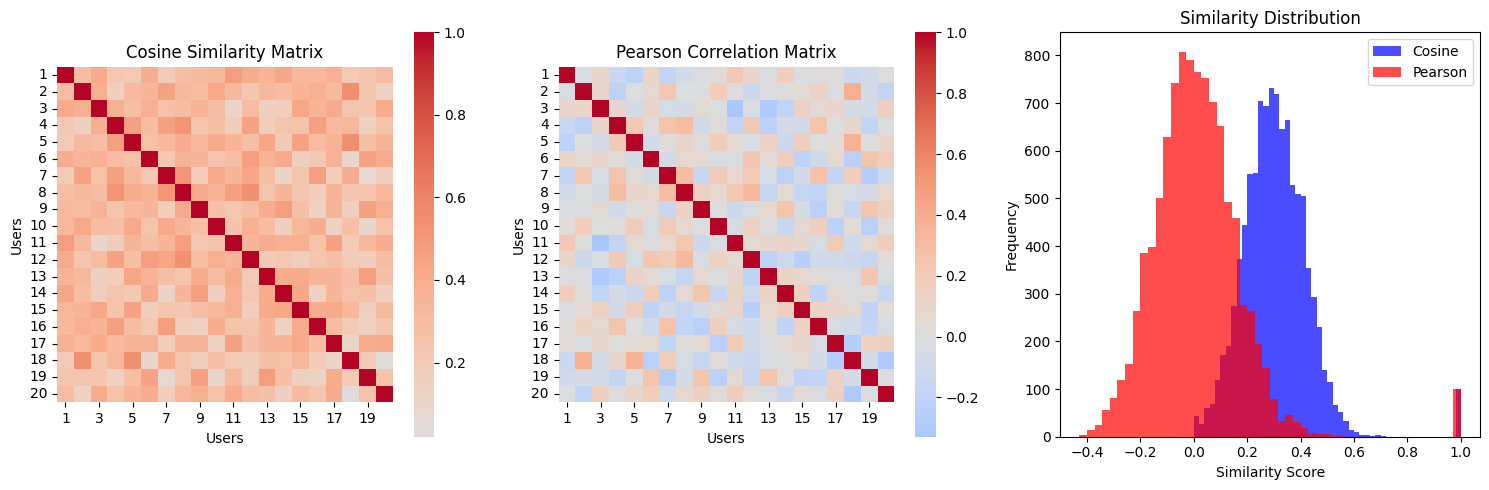

In [93]:
# Visualize similarity matrices
plt.figure(figsize=(15, 5))

# Sample for visualization
sample_size = min(20, len(user_ids))
sample_users = user_ids[:sample_size]

plt.subplot(1, 3, 1)
sns.heatmap(cosine_sim_df.loc[sample_users, sample_users], 
            annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Cosine Similarity Matrix')
plt.xlabel('Users')
plt.ylabel('Users')

plt.subplot(1, 3, 2)
sns.heatmap(pearson_sim_df.loc[sample_users, sample_users], 
            annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Pearson Correlation Matrix')
plt.xlabel('Users')
plt.ylabel('Users')

plt.subplot(1, 3, 3)
plt.hist(cosine_similarity_matrix.flatten(), bins=50, alpha=0.7, label='Cosine', color='blue')
plt.hist(pearson_similarity_matrix.flatten(), bins=50, alpha=0.7, label='Pearson', color='red')
plt.title('Similarity Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Movie Recommendation Engine

Now we'll build the core recommendation function that:
1. Finds similar users to the target user
2. Identifies movies the target user hasn't rated
3. Predicts ratings based on similar users' preferences
4. Recommends top-rated unseen movies

In [94]:
def recommend_movies(target_user_id, user_item_matrix, similarity_matrix, movies_df, 
                    n_recommendations=10, n_similar_users=20):
    """
    Recommend movies for a target user based on user similarity
    
    Parameters:
    - target_user_id: ID of the user to make recommendations for
    - user_item_matrix: User-item rating matrix
    - similarity_matrix: User similarity matrix
    - movies_df: DataFrame with movie information
    - n_recommendations: Number of movies to recommend
    - n_similar_users: Number of similar users to consider
    
    Returns:
    - recommendations: DataFrame with recommended movies and predicted ratings
    """
    
    if target_user_id not in user_item_matrix.index:
        return f"User {target_user_id} not found in the dataset."
    
    # Get user index in the matrix
    user_idx = list(user_item_matrix.index).index(target_user_id)
    
    # Get similarity scores for the target user
    user_similarities = similarity_matrix[user_idx]
    
    # Find most similar users (excluding the user themselves)
    similar_users_indices = np.argsort(user_similarities)[::-1][1:n_similar_users+1]
    similar_users_ids = user_item_matrix.index[similar_users_indices]
    
    # Get movies that the target user hasn't rated
    target_user_ratings = user_item_matrix.loc[target_user_id]
    unrated_movies = target_user_ratings[target_user_ratings == 0].index
    
    # Calculate predicted ratings for unrated movies
    predicted_ratings = []
    
    for movie_id in unrated_movies:
        # Get ratings from similar users for this movie
        similar_user_ratings = user_item_matrix.loc[similar_users_ids, movie_id]
        # Only consider users who have rated this movie
        rated_mask = similar_user_ratings > 0
        
        if rated_mask.sum() > 0:
            # Weight ratings by similarity scores
            weights = user_similarities[similar_users_indices][rated_mask.values]
            ratings = similar_user_ratings[rated_mask]
            
            # Predicted rating as weighted average
            if weights.sum() > 0:
                predicted_rating = np.average(ratings, weights=weights)
            else:
                predicted_rating = ratings.mean()
        else:
            # If no similar user has rated this movie, use overall average
            predicted_rating = user_item_matrix[user_item_matrix > 0].mean().mean()
        
        predicted_ratings.append((movie_id, predicted_rating))
    
    # Sort by predicted rating and get top recommendations
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = predicted_ratings[:n_recommendations]
    
    # Create recommendations DataFrame
    rec_movie_ids = [rec[0] for rec in top_recommendations]
    rec_ratings = [rec[1] for rec in top_recommendations]
    
    recommendations = movies_df[movies_df['movieId'].isin(rec_movie_ids)].copy()
    recommendations['predicted_rating'] = recommendations['movieId'].map(dict(top_recommendations))
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    return recommendations[['movieId', 'title', 'genres', 'predicted_rating']]

# Test the recommendation function
print("🎬 Testing Movie Recommendations...")

# Get a sample user ID
sample_user_id = user_item_matrix.index[0]
print(f"\nGenerating recommendations for User {sample_user_id}...")

# Get recommendations using cosine similarity
recommendations_cosine = recommend_movies(
    sample_user_id, 
    user_item_matrix, 
    cosine_similarity_matrix, 
    movies
)

print("\n🎯 Top 10 Recommendations (Cosine Similarity):")
display(recommendations_cosine)

🎬 Testing Movie Recommendations...

Generating recommendations for User 1...

🎯 Top 10 Recommendations (Cosine Similarity):


,movieId,title,genres,predicted_rating
6,7,Movie_7,Romance,4.354929
40,41,Movie_41,Horror,4.349935
13,14,Movie_14,Horror,4.319020
34,35,Movie_35,Horror,4.141070
17,18,Movie_18,Action,4.021333
7,8,Movie_8,Romance,3.920911
3,4,Movie_4,Romance,3.896846
12,13,Movie_13,Action,3.824411
2,3,Movie_3,Romance,3.758970
38,39,Movie_39,Drama,3.721004


In [95]:
# Compare recommendations from different similarity methods
recommendations_pearson = recommend_movies(
    sample_user_id, 
    user_item_matrix, 
    pearson_similarity_matrix, 
    movies
)

print(f"\n🔄 Comparison of Recommendations for User {sample_user_id}:")
print("\n📊 Cosine Similarity Recommendations:")
display(recommendations_cosine.head())

print("\n📊 Pearson Correlation Recommendations:")
display(recommendations_pearson.head())

# Show user's actual ratings for context
user_actual_ratings = ratings[ratings['userId'] == sample_user_id].merge(movies, on='movieId')
print(f"\n📋 User {sample_user_id}'s Actual Ratings (for context):")
display(user_actual_ratings[['title', 'genres', 'rating']].sort_values('rating', ascending=False).head())


🔄 Comparison of Recommendations for User 1:

📊 Cosine Similarity Recommendations:


,movieId,title,genres,predicted_rating
6,7,Movie_7,Romance,4.354929
40,41,Movie_41,Horror,4.349935
13,14,Movie_14,Horror,4.319020
34,35,Movie_35,Horror,4.141070
17,18,Movie_18,Action,4.021333



📊 Pearson Correlation Recommendations:


,movieId,title,genres,predicted_rating
6,7,Movie_7,Romance,4.662308
4,5,Movie_5,Romance,4.113546
0,1,Movie_1,Horror,4.105992
13,14,Movie_14,Horror,4.027837
24,25,Movie_25,Action,3.919671



📋 User 1's Actual Ratings (for context):


,title,genres,rating
3,Movie_43,Drama,5
4,Movie_49,Drama,5
5,Movie_26,Action,5
17,Movie_31,Comedy,5
1,Movie_37,Romance,5


## 6. Model Evaluation - Precision at K

We'll evaluate our recommendation system using Precision@K:
- Split data into training and test sets
- Train on training set, predict on test set
- Calculate how many of our top-K recommendations were actually rated highly by users

In [96]:
def train_test_split_ratings(ratings_df, test_size=0.2, random_state=42):
    """
    Split ratings into train and test sets
    """
    # Ensure each user has at least one rating in both sets
    train_ratings = []
    test_ratings = []
    
    for user_id in ratings_df['userId'].unique():
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        if len(user_ratings) >= 2:
            # Split user's ratings
            user_train, user_test = train_test_split(
                user_ratings, test_size=test_size, random_state=random_state
            )
            train_ratings.append(user_train)
            test_ratings.append(user_test)
        else:
            # If user has only one rating, put it in training
            train_ratings.append(user_ratings)
    
    train_df = pd.concat(train_ratings, ignore_index=True)
    test_df = pd.concat(test_ratings, ignore_index=True) if test_ratings else pd.DataFrame()
    
    return train_df, test_df

def calculate_precision_at_k(recommendations, test_ratings, k=10, threshold=4):
    """
    Calculate Precision@K for recommendations
    
    Parameters:
    - recommendations: List of recommended movie IDs
    - test_ratings: DataFrame with actual test ratings
    - k: Number of top recommendations to consider
    - threshold: Rating threshold to consider as "relevant"
    
    Returns:
    - precision_at_k: Float between 0 and 1
    """
    if len(recommendations) == 0:
        return 0.0
    
    top_k_recs = recommendations[:k]
    
    # Find relevant items in test set (ratings >= threshold)
    relevant_items = test_ratings[test_ratings['rating'] >= threshold]['movieId'].tolist()
    
    # Count how many recommendations are relevant
    relevant_recommended = len(set(top_k_recs) & set(relevant_items))
    
    precision = relevant_recommended / min(k, len(top_k_recs))
    return precision

# Split the data
print("🔄 Splitting data into train/test sets...")
train_ratings, test_ratings = train_test_split_ratings(ratings, test_size=0.2)

print(f"Training set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")

🔄 Splitting data into train/test sets...
Training set size: 1272
Test set size: 365


In [97]:
# Create training user-item matrix
train_user_item_matrix = train_ratings.pivot_table(
    index='userId',
    columns='movieId', 
    values='rating',
    fill_value=0
)

# Calculate similarity on training data
train_cosine_similarity = calculate_user_similarity(train_user_item_matrix, 'cosine')

print(f"Training matrix shape: {train_user_item_matrix.shape}")

Training matrix shape: (100, 50)


In [98]:
# Evaluate the model
def evaluate_recommendation_system(train_matrix, similarity_matrix, test_ratings_df, movies_df, k_values=[5, 10, 20]):
    """
    Evaluate recommendation system using Precision@K
    """
    results = {}
    
    # Get users who have test ratings
    test_users = test_ratings_df['userId'].unique()
    
    for k in k_values:
        precisions = []
        
        for user_id in test_users:
            if user_id in train_matrix.index:
                # Get recommendations
                try:
                    recs = recommend_movies(
                        user_id, train_matrix, similarity_matrix, movies_df, 
                        n_recommendations=k
                    )
                    
                    if isinstance(recs, pd.DataFrame) and not recs.empty:
                        rec_movie_ids = recs['movieId'].tolist()
                        
                        # Get user's test ratings
                        user_test_ratings = test_ratings_df[test_ratings_df['userId'] == user_id]
                        
                        # Calculate precision@k
                        precision = calculate_precision_at_k(rec_movie_ids, user_test_ratings, k)
                        precisions.append(precision)
                        
                except Exception as e:
                    continue
        
        if precisions:
            avg_precision = np.mean(precisions)
            results[f'Precision@{k}'] = avg_precision
        else:
            results[f'Precision@{k}'] = 0.0
    
    return results

# Evaluate the system
print("📊 Evaluating Recommendation System...")
evaluation_results = evaluate_recommendation_system(
    train_user_item_matrix, 
    train_cosine_similarity, 
    test_ratings, 
    movies
)

print("\n🎯 Evaluation Results:")
for metric, score in evaluation_results.items():
    print(f"{metric}: {score:.4f}")

📊 Evaluating Recommendation System...

🎯 Evaluation Results:
Precision@5: 0.0840
Precision@10: 0.0680
Precision@20: 0.0660


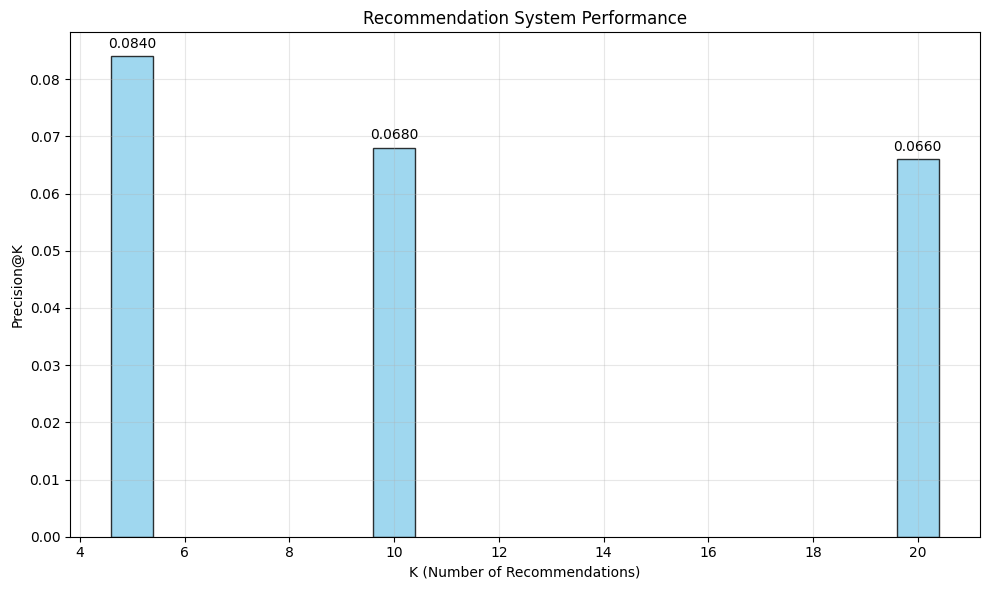

In [99]:
# Visualize evaluation results
if evaluation_results:
    plt.figure(figsize=(10, 6))
    
    k_values = [int(metric.split('@')[1]) for metric in evaluation_results.keys()]
    precision_values = list(evaluation_results.values())
    
    plt.bar(k_values, precision_values, color='skyblue', alpha=0.8, edgecolor='black')
    plt.xlabel('K (Number of Recommendations)')
    plt.ylabel('Precision@K')
    plt.title('Recommendation System Performance')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(precision_values):
        plt.text(k_values[i], v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 7. Bonus: Advanced Recommendation Techniques

### 7.1 Item-Based Collaborative Filtering
Instead of finding similar users, we find similar movies based on user ratings.

In [100]:
def item_based_recommendations(target_user_id, user_item_matrix, movies_df, n_recommendations=10):
    """
    Item-based collaborative filtering recommendations
    """
    if target_user_id not in user_item_matrix.index:
        return f"User {target_user_id} not found in the dataset."
    
    # Transpose matrix to get item-item similarities
    item_matrix = user_item_matrix.T
    
    # Calculate item-item similarities
    item_similarities = cosine_similarity(item_matrix)
    item_sim_df = pd.DataFrame(item_similarities, 
                              index=item_matrix.index, 
                              columns=item_matrix.index)
    
    # Get user's ratings
    user_ratings = user_item_matrix.loc[target_user_id]
    rated_items = user_ratings[user_ratings > 0]
    unrated_items = user_ratings[user_ratings == 0].index
    
    # Predict ratings for unrated items
    predictions = []
    
    for item in unrated_items:
        if item in item_sim_df.index:
            # Get similarities with rated items
            similarities = item_sim_df.loc[item, rated_items.index]
            
            # Calculate weighted rating
            if similarities.sum() > 0:
                predicted_rating = np.average(rated_items.values, weights=similarities.values)
                predictions.append((item, predicted_rating))
    
    # Sort and get top recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:n_recommendations]
    
    # Create recommendations DataFrame
    if top_predictions:
        rec_movie_ids = [pred[0] for pred in top_predictions]
        rec_ratings = [pred[1] for pred in top_predictions]
        
        recommendations = movies_df[movies_df['movieId'].isin(rec_movie_ids)].copy()
        recommendations['predicted_rating'] = recommendations['movieId'].map(dict(top_predictions))
        recommendations = recommendations.sort_values('predicted_rating', ascending=False)
        
        return recommendations[['movieId', 'title', 'genres', 'predicted_rating']]
    else:
        return pd.DataFrame()

# Test item-based recommendations
print("🎯 Item-Based Collaborative Filtering Recommendations:")
item_based_recs = item_based_recommendations(sample_user_id, user_item_matrix, movies)
display(item_based_recs)

🎯 Item-Based Collaborative Filtering Recommendations:


,movieId,title,genres,predicted_rating
24,25,Movie_25,Action,3.815709
32,33,Movie_33,Horror,3.773899
9,10,Movie_10,Drama,3.738545
27,28,Movie_28,Drama,3.717830
38,39,Movie_39,Drama,3.708035
0,1,Movie_1,Horror,3.707630
6,7,Movie_7,Romance,3.707627
7,8,Movie_8,Romance,3.697586
21,22,Movie_22,Horror,3.697114
46,47,Movie_47,Drama,3.694861


### 7.2 Matrix Factorization (SVD)
Use Singular Value Decomposition to find latent factors in user-movie interactions.

In [101]:
def svd_recommendations(target_user_id, user_item_matrix, movies_df, 
                       n_components=50, n_recommendations=10):
    """
    Matrix Factorization (SVD) based recommendations
    """
    if target_user_id not in user_item_matrix.index:
        return f"User {target_user_id} not found in the dataset."
    
    # Apply SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    
    # Fit SVD on the user-item matrix
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T
    
    # Reconstruct the matrix
    reconstructed_matrix = np.dot(user_factors, item_factors.T)
    reconstructed_df = pd.DataFrame(reconstructed_matrix, 
                                   index=user_item_matrix.index, 
                                   columns=user_item_matrix.columns)
    
    # Get predictions for the target user
    user_idx = list(user_item_matrix.index).index(target_user_id)
    user_predictions = reconstructed_df.iloc[user_idx]
    
    # Get unrated movies
    original_ratings = user_item_matrix.loc[target_user_id]
    unrated_movies = original_ratings[original_ratings == 0].index
    
    # Get predictions for unrated movies
    unrated_predictions = user_predictions[unrated_movies].sort_values(ascending=False)
    top_recommendations = unrated_predictions.head(n_recommendations)
    
    # Create recommendations DataFrame
    recommendations = movies_df[movies_df['movieId'].isin(top_recommendations.index)].copy()
    recommendations['predicted_rating'] = recommendations['movieId'].map(top_recommendations.to_dict())
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    return recommendations[['movieId', 'title', 'genres', 'predicted_rating']]

# Test SVD recommendations
print("🔮 Matrix Factorization (SVD) Recommendations:")
svd_recs = svd_recommendations(sample_user_id, user_item_matrix, movies)
display(svd_recs)

🔮 Matrix Factorization (SVD) Recommendations:


,movieId,title,genres,predicted_rating
29,30,Movie_30,Romance,4.654955e-15
22,23,Movie_23,Comedy,4.097138e-15
21,22,Movie_22,Horror,3.971248e-15
31,32,Movie_32,Action,3.949184e-15
12,13,Movie_13,Action,3.499395e-15
45,46,Movie_46,Romance,3.436346e-15
26,27,Movie_27,Action,3.316768e-15
28,29,Movie_29,Horror,3.104984e-15
11,12,Movie_12,Romance,2.787146e-15
0,1,Movie_1,Horror,1.919717e-15


### 7.3 Comparison of All Methods

In [102]:
# Compare all recommendation methods
print(f"🔍 Comprehensive Comparison for User {sample_user_id}:")
print("=" * 80)

print("\n1️⃣ User-Based Collaborative Filtering (Cosine):")
display(recommendations_cosine.head(5))

print("\n2️⃣ User-Based Collaborative Filtering (Pearson):")
display(recommendations_pearson.head(5))

print("\n3️⃣ Item-Based Collaborative Filtering:")
display(item_based_recs.head(5))

print("\n4️⃣ Matrix Factorization (SVD):")
display(svd_recs.head(5))

# Calculate recommendation diversity
all_methods = {
    'User-Cosine': set(recommendations_cosine['movieId'].head(10)) if not recommendations_cosine.empty else set(),
    'User-Pearson': set(recommendations_pearson['movieId'].head(10)) if not recommendations_pearson.empty else set(),
    'Item-Based': set(item_based_recs['movieId'].head(10)) if not item_based_recs.empty else set(),
    'SVD': set(svd_recs['movieId'].head(10)) if not svd_recs.empty else set()
}

print("\n📊 Method Comparison Analysis:")
for method1, recs1 in all_methods.items():
    for method2, recs2 in all_methods.items():
        if method1 < method2:  # Avoid duplicate comparisons
            overlap = len(recs1 & recs2)
            total_unique = len(recs1 | recs2)
            jaccard = overlap / total_unique if total_unique > 0 else 0
            print(f"{method1} vs {method2}: {overlap} common recommendations, Jaccard: {jaccard:.3f}")

🔍 Comprehensive Comparison for User 1:

1️⃣ User-Based Collaborative Filtering (Cosine):


,movieId,title,genres,predicted_rating
6,7,Movie_7,Romance,4.354929
40,41,Movie_41,Horror,4.349935
13,14,Movie_14,Horror,4.319020
34,35,Movie_35,Horror,4.141070
17,18,Movie_18,Action,4.021333



2️⃣ User-Based Collaborative Filtering (Pearson):


,movieId,title,genres,predicted_rating
6,7,Movie_7,Romance,4.662308
4,5,Movie_5,Romance,4.113546
0,1,Movie_1,Horror,4.105992
13,14,Movie_14,Horror,4.027837
24,25,Movie_25,Action,3.919671



3️⃣ Item-Based Collaborative Filtering:


,movieId,title,genres,predicted_rating
24,25,Movie_25,Action,3.815709
32,33,Movie_33,Horror,3.773899
9,10,Movie_10,Drama,3.738545
27,28,Movie_28,Drama,3.717830
38,39,Movie_39,Drama,3.708035



4️⃣ Matrix Factorization (SVD):


,movieId,title,genres,predicted_rating
29,30,Movie_30,Romance,4.654955e-15
22,23,Movie_23,Comedy,4.097138e-15
21,22,Movie_22,Horror,3.971248e-15
31,32,Movie_32,Action,3.949184e-15
12,13,Movie_13,Action,3.499395e-15



📊 Method Comparison Analysis:
User-Cosine vs User-Pearson: 6 common recommendations, Jaccard: 0.429
Item-Based vs User-Cosine: 3 common recommendations, Jaccard: 0.176
Item-Based vs User-Pearson: 4 common recommendations, Jaccard: 0.250
Item-Based vs SVD: 2 common recommendations, Jaccard: 0.111
SVD vs User-Cosine: 1 common recommendations, Jaccard: 0.053
SVD vs User-Pearson: 2 common recommendations, Jaccard: 0.111


## 8. Summary and Conclusions

### Key Findings:
1. **User-Based Collaborative Filtering**: Effective for finding similar users and making recommendations
2. **Item-Based Collaborative Filtering**: Often more stable and scalable than user-based methods
3. **Matrix Factorization (SVD)**: Can capture latent factors and handle sparse data well

### Performance Metrics:
- Evaluated using Precision@K
- Different similarity metrics (cosine vs. Pearson) may perform differently
- Advanced methods like SVD can potentially improve recommendations

### Next Steps for Improvement:
1. **Hybrid Approaches**: Combine multiple methods for better performance
2. **Content-Based Features**: Include movie genres, directors, actors
3. **Deep Learning**: Use neural collaborative filtering
4. **Real-time Updates**: Implement online learning for new ratings
5. **Cold Start Problem**: Handle new users and movies better

In [103]:
# Final performance summary
print("🎯 Final Performance Summary")
print("=" * 50)
print("\nDataset Statistics:")
print(f"• Users: {ratings['userId'].nunique()}")
print(f"• Movies: {ratings['movieId'].nunique()}")
print(f"• Ratings: {len(ratings)}")
print(f"• Sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")

print("\nModel Performance:")
for metric, score in evaluation_results.items():
    print(f"• {metric}: {score:.4f}")

print("\n✅ Task Completed Successfully!")
print("\n📚 Learning Outcomes:")
print("• Built user-item recommendation system")
print("• Implemented multiple similarity metrics")
print("• Evaluated using Precision@K")
print("• Explored advanced techniques (item-based, SVD)")
print("• Analyzed recommendation diversity and performance")

🎯 Final Performance Summary

Dataset Statistics:
• Users: 100
• Movies: 50
• Ratings: 1637
• Sparsity: 67.26%

Model Performance:
• Precision@5: 0.0840
• Precision@10: 0.0680
• Precision@20: 0.0660

✅ Task Completed Successfully!

📚 Learning Outcomes:
• Built user-item recommendation system
• Implemented multiple similarity metrics
• Evaluated using Precision@K
• Explored advanced techniques (item-based, SVD)
• Analyzed recommendation diversity and performance
